# DVA263 project

# Libraries

Declaring all libraries in use

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import os
import cnn as cnn
import preprocessing as pre
import visualization as vis


# Load Dataset

In [2]:
def load_cnn():
    """Load the datasets for the CNN input"""
    CNN_train = "../dataset/CNN_Input/train/"
    CNN_test = "../dataset/CNN_Input/test/"
    CNN_train = pre.import_images(CNN_train, (150,150),batch_size=16, dataset=True)
    CNN_test = pre.import_images(CNN_test, (150,150), batch_size=16,  dataset=True)
    return CNN_train, CNN_test

# Prepare Data

In [3]:
def prep_cnn(cnn_train, cnn_test):
    """Add noise images to train and test set and normalize"""
    g_noisy_train_data = cnn_train.map(pre.add_gaussian_noise)
    snp_noisy_train_data = cnn_train.map(pre.add_salt_and_pepper_noise)
    combined_train_data = cnn_train.concatenate(g_noisy_train_data).concatenate(snp_noisy_train_data)

    percentage_noisy_images = 0.2
    total_test_images = len(CNN_test) * 16  # Total images in test data
    num_noisy_images = int(total_test_images * percentage_noisy_images)

    g_noisy_test_data = cnn_test.take(num_noisy_images).map(pre.add_gaussian_noise)
    snp_noisy_test_data = cnn_test.take(num_noisy_images).map(pre.add_salt_and_pepper_noise)
    remaining_test_data = cnn_test.skip(num_noisy_images)

    combined_test_data = g_noisy_test_data.concatenate(remaining_test_data)
    combined_test_data = combined_test_data.concatenate(snp_noisy_test_data)

    test_data_norm, train_data_norm = pre.normalize_img(combined_train_data, combined_test_data)
    return train_data_norm, test_data_norm


# Build and Compile Model

In [4]:
def build_cnn():
    model = cnn.build_cnn_model()
    return model

#  Train Model

In [5]:
def train_cnn(model,cnn_train, cnn_test):
    history = cnn.train_model(model, cnn_train, cnn_test)
    return history

# Putting everything together

Main section putting each part together and running the classification task

Found 83 files belonging to 4 classes.
Found 62 files belonging to 4 classes.
Epoch 1/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.2576 - loss: 1.4064 - val_accuracy: 0.2581 - val_loss: 1.3844 - learning_rate: 0.0010
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.2939 - loss: 1.3831 - val_accuracy: 0.2823 - val_loss: 1.3806 - learning_rate: 0.0010
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.3001 - loss: 1.3790 - val_accuracy: 0.3145 - val_loss: 1.3746 - learning_rate: 0.0010
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.3302 - loss: 1.3663 - val_accuracy: 0.2984 - val_loss: 1.3545 - learning_rate: 0.0010
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.3153 - loss: 1.3507 - val_accuracy: 0.4516 - val_loss: 1.3129 - learning_rate: 0.0010
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4382 - loss: 1.2778 - val_accuracy: 0.5000 - val_loss: 1.1717 - learning_rate: 0.0010
Epoch 7/70
18/1

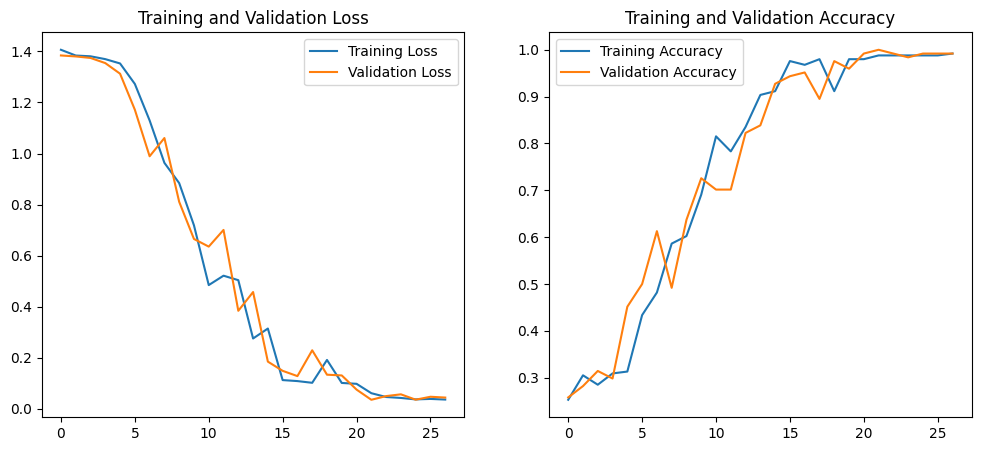

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


array([[5.14828569e-10, 1.25747775e-07, 9.93468523e-01, 6.53130049e-03],
       [9.87978339e-01, 1.20206503e-02, 1.06374876e-09, 1.03523519e-06],
       [9.99883652e-01, 1.15969713e-04, 4.33831726e-09, 3.14050538e-07],
       [9.98764157e-01, 1.18258735e-03, 3.44287473e-05, 1.88404611e-05],
       [9.96918917e-01, 2.84523703e-03, 1.68000054e-06, 2.34171297e-04],
       [2.00051636e-06, 3.02685635e-07, 9.99354899e-01, 6.42741623e-04],
       [2.76226318e-04, 9.99717891e-01, 1.42409795e-06, 4.37846757e-06],
       [8.42891241e-05, 1.71677631e-04, 1.19656503e-01, 8.80087554e-01],
       [7.45828345e-07, 7.57884152e-07, 9.92291749e-01, 7.70683773e-03],
       [8.77657719e-03, 9.91216779e-01, 3.78449806e-11, 6.56784732e-06],
       [9.99836206e-01, 2.53261442e-05, 6.58230274e-05, 7.26239305e-05],
       [9.64692026e-06, 1.06885633e-03, 4.41653188e-03, 9.94504869e-01],
       [5.50260411e-05, 9.99941826e-01, 2.13072212e-06, 1.01400917e-06],
       [4.28283231e-09, 2.62043738e-08, 9.99626994e

In [7]:
CNN_train, CNN_test = load_cnn()
CNN_train, CNN_test = prep_cnn(CNN_train, CNN_test)
CNN_model = build_cnn()
cnn_history = train_cnn(CNN_model, CNN_train, CNN_test)
vis.plot_metrics(cnn_history)

CNN_model.predict(CNN_test) # here we will use the output from the autoencoder.